In [1]:
import os
import sys
import re

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

sys.path.append(os.path.realpath('.'))
sys.path.append(os.path.join(os.path.expanduser('~'), 'bnelearn'))

from scripts.utils import *
from bnelearn.util.metrics import *

BNE envs have been set up.


In [2]:
# COLORS = (0/255.,150/255.,196/255.),(248/255.,118/255.,109/255.),(150/255.,120/255.,170/255.),(255/255.,215/255.,130/255.)
# COLORS = ("#FF412C", "#9F29FF", "#31CAA8", "#06A6EE", "#CCD1DB")
COLORS = ("#0E6BA0", "#973D4C", "#30C0D2",)

In [3]:
def split_mean_and_std_of_df_column(df, metric):
    df[[metric + ' mean', metric + ' std']] = df[metric].str.split(' ', 1, expand=True)
    df[metric + ' std'] = df[metric + ' std'].apply(lambda x: x[1:-1])
    df[metric + ' mean'] = df[metric + ' mean'].astype(float)
    df[metric + ' std'] = df[metric + ' std'].astype(float)
    return df[metric + ' mean'].to_numpy(), df[metric + ' std'].to_numpy()

---
## 1. Single item experiment

In [4]:
metric = "eval_vs_bne/L_2"

paths = {
    "Smooth Market": "/home/kohring/bnelearn/experiments/smooth/single_item/single_item/first_price/uniform/symmetric/risk_neutral/2p/2022-05-19 Thu 11:14:16/full_results.csv",
    "NPGA": "/home/kohring/bnelearn/experiments/smooth/single_item/single_item/first_price/uniform/symmetric/risk_neutral/2p/2022-05-19 Thu 11:17:22/full_results.csv"
}

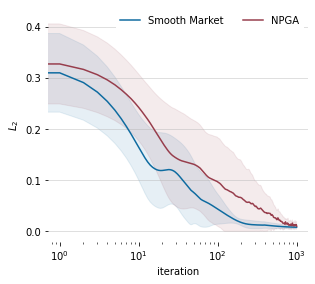

In [5]:
fig, ax = plt.subplots(figsize=(4.5, 4))

for i, (key, path) in enumerate(paths.items()):
    df = pd.read_csv(path)
    df = df.loc[df['tag'] == metric]
    df = df.groupby(['epoch']).agg({'value': ['mean', 'std']})
    df.columns = ['means', 'stds']
    
    x = df.index.to_numpy()
    means, stds = df.means.to_numpy(), df.stds.to_numpy()

    plt.plot(x, means, "-", label=key, color=COLORS[i])
    plt.fill_between(x, np.clip(means-stds, 0, 10), means+stds, color=COLORS[i], alpha=.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(which='major', axis='y', alpha=.5)

plt.xlabel('iteration'); plt.ylabel(ALIASES_LATEX[metric])
# plt.xlim([-0.003, 0.103])
# plt.ylim([-0.003, 0.073])
plt.legend(loc='upper right', ncol=2, framealpha=1, edgecolor="white")
plt.tight_layout()
plt.semilogx()
plt.savefig(path[:-40] + f"single_item_analysis.pdf")
plt.show()

In [6]:
metrics = ["eval_vs_bne/L_2", 'meta/iter_time']
paths = [
    "/home/kohring/bnelearn/experiments/smooth/single_item/single_item/first_price/uniform/symmetric/risk_neutral/2p/2022-05-19 Thu 11:14:16/",
    "/home/kohring/bnelearn/experiments/smooth/single_item/single_item/first_price/uniform/symmetric/risk_neutral/2p/2022-05-19 Thu 11:17:22/",
    "/home/kohring/bnelearn/experiments/smooth/single_item/single_item/second_price/uniform/symmetric/risk_neutral/2p/2022-05-19 Thu 13:43:57/",
    "/home/kohring/bnelearn/experiments/smooth/single_item/single_item/second_price/uniform/symmetric/risk_neutral/2p/2022-05-19 Thu 13:51:03/",
]

In [7]:
aggregate_df = pd.DataFrame()
for i, path in enumerate(paths):
    df = multiple_exps_logs_to_df(
        path=path,
        metrics=metrics,
        with_setting_parameters=True
    )
    df = df[["Smoothing", "Pricing"] + [ALIASES_LATEX[m] for m in metrics]]
    df["Smoothing"] = df["Smoothing"].apply(lambda x: "NPGA" if x is None else "SM")
    df = df.rename(columns={"Smoothing": "Algo."})
    aggregate_df = pd.concat([aggregate_df, df])
df_to_tex(aggregate_df, name='single_item_table.tex', label='tab:single_item', caption='Results of the single-item experiments.')
aggregate_df.head()

/home/kohring/bnelearn/scripts/utils.py:258: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(


,Algo.,Pricing,$L_2$,$t/$iter
/home/kohring/bnelearn/experiments/smooth/single_item/single_item/first_price/uniform/symmetric/risk_neutral/2p/2022-05-19 Thu 11:14:16/aggregate_log.csv,SM,FPSB,0.0080 (0.0028),0.0081 (0.0005)
/home/kohring/bnelearn/experiments/smooth/single_item/single_item/first_price/uniform/symmetric/risk_neutral/2p/2022-05-19 Thu 11:17:22/aggregate_log.csv,NPGA,FPSB,0.0100 (0.0060),0.1361 (0.0019)
/home/kohring/bnelearn/experiments/smooth/single_item/single_item/second_price/uniform/symmetric/risk_neutral/2p/2022-05-19 Thu 13:43:57/aggregate_log.csv,SM,SPSB,0.0048 (0.0021),0.0126 (0.0006)
/home/kohring/bnelearn/experiments/smooth/single_item/single_item/second_price/uniform/symmetric/risk_neutral/2p/2022-05-19 Thu 13:51:03/aggregate_log.csv,NPGA,SPSB,0.0178 (0.0142),0.2039 (0.0121)


---
## 2. LLG experiment

In [8]:
metrics = ["eval_vs_bne/L_2", 'meta/iter_time']
paths = [
    "/home/kohring/bnelearn/experiments/smooth/llg/LLG/nearest_zero/independent/2022-05-31 Tue 21:04:35/full_results.csv",
    "/home/kohring/bnelearn/experiments/smooth/llg/LLG/nearest_zero/independent/2022-05-31 Tue 21:47:47/full_results.csv",
    "/home/kohring/bnelearn/experiments/smooth/llg/LLG/vcg/independent/2022-05-31 Tue 21:06:06/full_results.csv",
    "/home/kohring/bnelearn/experiments/smooth/llg/LLG/vcg/independent/2022-05-31 Tue 21:43:51/full_results.csv",
]

In [9]:
aggregate_df = pd.DataFrame()
for path in paths:
    df = single_asym_exp_logs_to_df(
        path,
        metrics=metrics,
        with_stddev=True
    )
    df = df[["Smoothing", "Pricing", "bidder"] + [ALIASES_LATEX[m] for m in metrics]]
    df["Smoothing"] = df["Smoothing"].apply(lambda x: "NPGA" if x is None else "SM")
    df = df.rename(columns={"Smoothing": "Algo.", "bidder": "Bidder"})
    aggregate_df = pd.concat([aggregate_df, df])

df_to_tex(aggregate_df, name='llg_table.tex', label='tab:llg', caption='Results of the LLG experiments.')
aggregate_df.head(16)

/home/kohring/bnelearn/scripts/utils.py:258: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(


,Algo.,Pricing,bidder,$L_2$,$t/$iter
bidder,,,,,
.,SM,NZ,.,NaN,0.0272 (0.0014)
global,SM,NZ,global,0.0063 (0.0005),NaN
locals,SM,NZ,locals,0.0070 (0.0032),NaN
.,NPGA,NZ,.,NaN,0.3914 (0.0042)
global,NPGA,NZ,global,0.0123 (0.0018),NaN
locals,NPGA,NZ,locals,0.0124 (0.0036),NaN
.,SM,VCG,.,NaN,0.0238 (0.0014)
global,SM,VCG,global,0.0064 (0.0009),NaN
locals,SM,VCG,locals,0.0016 (0.0003),NaN


---
## 3. Temperature experiment

In [10]:
configs = {
    "players":{
        "var_name": "n",
        "vars": [2, 3, 4],
    },
    "items":{
        "var_name": "m",
        "vars": [1, 2],
    },
    "batch_size":{
        "var_name": "h",
        "vars": [2**12, 2**18, 2**23],
    },
}

In [11]:
exp = "players"
# exp = "items"
# exp = "batch_size"
config = configs[exp]

In [12]:
metrics = ['eval_vs_bne/L_2']
metric = "$L_2$"
path = f"/home/kohring/bnelearn/experiments/smooth/temperature/{exp}/single_item/first_price/uniform/symmetric/risk_neutral/"

TypeError: multiple_exps_logs_to_df() got an unexpected keyword argument 'with_stddev'

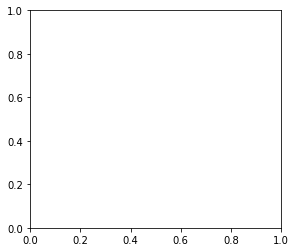

In [13]:
fig, ax = plt.subplots(figsize=(4.5, 4))

for i, var in enumerate(config['vars']):
    df = multiple_exps_logs_to_df(
        path=path + str(var) + "p" if exp == "players" else path + "2p",
        metrics=metrics,
        with_setting_parameters=True,
        with_stddev=True
    )
    if exp == "items":
        df = df[df["Units"] == var]
    elif exp == "batch_size":
        df = df[df["Batch"] == var]
    df.sort_values("Smoothing", inplace=True)
    smoothing = df.Smoothing.to_numpy()
    means, stds = split_mean_and_std_of_df_column(df, metric)

    smoothing_inter = np.arange(smoothing[0], smoothing[-1], 0.001)
    means_inter = interpolate.interp1d(smoothing, means, kind='quadratic')(smoothing_inter)
    stds_inter = interpolate.interp1d(smoothing, stds, kind='quadratic')(smoothing_inter)

    plt.plot(smoothing_inter, means_inter, "-", linewidth=1.7, color=COLORS[i])
    plt.plot(smoothing, means, "s", markersize=4, label=f"${config['var_name']} = {var}$", color=COLORS[i])
    plt.fill_between(smoothing_inter, np.clip(means_inter-stds_inter, 0, 10), means_inter+stds_inter, color=COLORS[i], alpha=.1)

    # plot optimum
    index_optimum = np.argmin(means_inter)
    plt.plot(smoothing_inter[index_optimum], means_inter[index_optimum], "v", markersize=10, color=COLORS[i])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(which='major', axis='y', alpha=.5)

plt.xlabel('temperature $\lambda$'); plt.ylabel(metric)
plt.xlim([-0.003, 0.103])
plt.ylim([-0.003, 0.073])
plt.legend(loc='upper right', ncol=3, framealpha=1, edgecolor="white")
plt.tight_layout()
plt.savefig(path + f"temperature_{exp}_analysis.pdf")
plt.show()